Import libraries

In [246]:
# Data manipulation and file handling
import pandas as pd  # for data manipulation
import pyarrow.feather as feather  # for reading/writing Feather files

# Modeling and machine learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier  # example model
from sklearn.metrics import accuracy_score, classification_report  # evaluation metrics

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


In [247]:
# Open training 
df= pd.read_feather('../data/processed/train_data.feather')

In [248]:
# Open testing
tdf = pd.read_feather('../data/processed/test_data.feather')

In [249]:
df.head()

,searchDate,flightDate,startingAirport,destinationAirport,isNonStop,totalFare,totalTravelDistance,segmentsArrivalAirportCode,DepartureTimeHour,CabinCode,AirlineNameScore,date_diff_days,weekday
3767896,2022-04-18,2022-05-06,LGA,DFW,True,93.599998,1380.0,DFW,8,1.0,2,18,4
929418,2022-05-11,2022-05-18,BOS,IAD,False,207.600006,406.0,JFK||IAD,11,1.0,4,7,2
5456598,2022-05-08,2022-06-21,ORD,EWR,False,358.600006,725.0,DTW||EWR,14,1.0,4,44,1
4876708,2022-05-08,2022-05-18,OAK,BOS,False,728.599976,2688.0,SLC||BOS,17,1.0,4,10,2
2004101,2022-05-12,2022-07-01,DFW,ATL,True,228.600006,725.0,ATL,19,1.0,4,50,4


In [250]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5106602 entries, 3767896 to 1692743
Data columns (total 13 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   searchDate                  datetime64[ns]
 1   flightDate                  datetime64[ns]
 2   startingAirport             object        
 3   destinationAirport          object        
 4   isNonStop                   bool          
 5   totalFare                   float32       
 6   totalTravelDistance         float32       
 7   segmentsArrivalAirportCode  object        
 8   DepartureTimeHour           uint8         
 9   CabinCode                   float32       
 10  AirlineNameScore            uint8         
 11  date_diff_days              uint16        
 12  weekday                     uint8         
dtypes: bool(1), datetime64[ns](2), float32(3), object(3), uint16(1), uint8(3)
memory usage: 321.4+ MB


In [251]:
df.shape

(5106602, 13)

In [252]:

# Calculate average price per route
route_avg_price = (
    df.groupby(['startingAirport', 'destinationAirport'])['totalFare']
    .mean()
    .reset_index()
    .rename(columns={'totalFare': 'average_price'})
)

# Merge this back to the original dataset
data = df.merge(route_avg_price, on=['startingAirport', 'destinationAirport'], how='left')

In [253]:
data.head()

,searchDate,flightDate,startingAirport,destinationAirport,isNonStop,totalFare,totalTravelDistance,segmentsArrivalAirportCode,DepartureTimeHour,CabinCode,AirlineNameScore,date_diff_days,weekday,average_price
0,2022-04-18,2022-05-06,LGA,DFW,True,93.599998,1380.0,DFW,8,1.0,2,18,4,218.513184
1,2022-05-11,2022-05-18,BOS,IAD,False,207.600006,406.0,JFK||IAD,11,1.0,4,7,2,233.873978
2,2022-05-08,2022-06-21,ORD,EWR,False,358.600006,725.0,DTW||EWR,14,1.0,4,44,1,233.211212
3,2022-05-08,2022-05-18,OAK,BOS,False,728.599976,2688.0,SLC||BOS,17,1.0,4,10,2,597.794067
4,2022-05-12,2022-07-01,DFW,ATL,True,228.600006,725.0,ATL,19,1.0,4,50,4,260.961975


In [254]:
# Display a few sample rows with 'startingAirport', 'destinationAirport', 'totalFare', and 'average_price'
print(data[['startingAirport', 'destinationAirport', 'totalFare', 'average_price']].sample(10))


        startingAirport destinationAirport   totalFare  average_price
2110740             ATL                DTW  404.600006     276.538361
4620614             BOS                PHL  318.579987     215.690231
2830881             LGA                ORD   83.599998     182.396484
4822466             ORD                PHL  183.600006     259.498596
398717              LGA                DTW  205.600006     204.956390
557065              EWR                LAX  533.599976     399.114136
2505997             LAX                LGA  377.600006     408.128479
205403              SFO                CLT  674.599976     613.071045
1945357             BOS                JFK   93.599998     177.429489
1692645             LGA                ORD  166.610001     182.396484


In [255]:
# Step 3: Merge the same average price into the test set
# This will apply the training-set-based averages to the test set routes
tdf = tdf.merge(route_avg_price, on=['startingAirport', 'destinationAirport'], how='left')

In [256]:
tdf.head()

,searchDate,flightDate,startingAirport,destinationAirport,isNonStop,totalFare,totalTravelDistance,segmentsArrivalAirportCode,DepartureTimeHour,CabinCode,AirlineNameScore,date_diff_days,weekday,average_price
0,2022-05-02,2022-05-28,LAX,CLT,True,555.609985,2121.0,CLT,7,1.0,4,26,5,463.072906
1,2022-05-03,2022-06-21,DEN,CLT,False,394.200012,1800.0,IAD||CLT,23,1.0,4,49,1,390.585907
2,2022-05-06,2022-05-09,SFO,ORD,True,758.599976,1847.0,ORD,10,1.0,4,3,0,518.917725
3,2022-05-03,2022-05-17,LAX,DTW,False,338.589996,NaN,LAS||DTW,13,1.0,1,14,1,447.044220
4,2022-05-02,2022-06-13,SFO,DFW,True,308.600006,1468.0,DAL,9,1.0,4,42,0,394.781616


In [257]:
data.head()

,searchDate,flightDate,startingAirport,destinationAirport,isNonStop,totalFare,totalTravelDistance,segmentsArrivalAirportCode,DepartureTimeHour,CabinCode,AirlineNameScore,date_diff_days,weekday,average_price
0,2022-04-18,2022-05-06,LGA,DFW,True,93.599998,1380.0,DFW,8,1.0,2,18,4,218.513184
1,2022-05-11,2022-05-18,BOS,IAD,False,207.600006,406.0,JFK||IAD,11,1.0,4,7,2,233.873978
2,2022-05-08,2022-06-21,ORD,EWR,False,358.600006,725.0,DTW||EWR,14,1.0,4,44,1,233.211212
3,2022-05-08,2022-05-18,OAK,BOS,False,728.599976,2688.0,SLC||BOS,17,1.0,4,10,2,597.794067
4,2022-05-12,2022-07-01,DFW,ATL,True,228.600006,725.0,ATL,19,1.0,4,50,4,260.961975


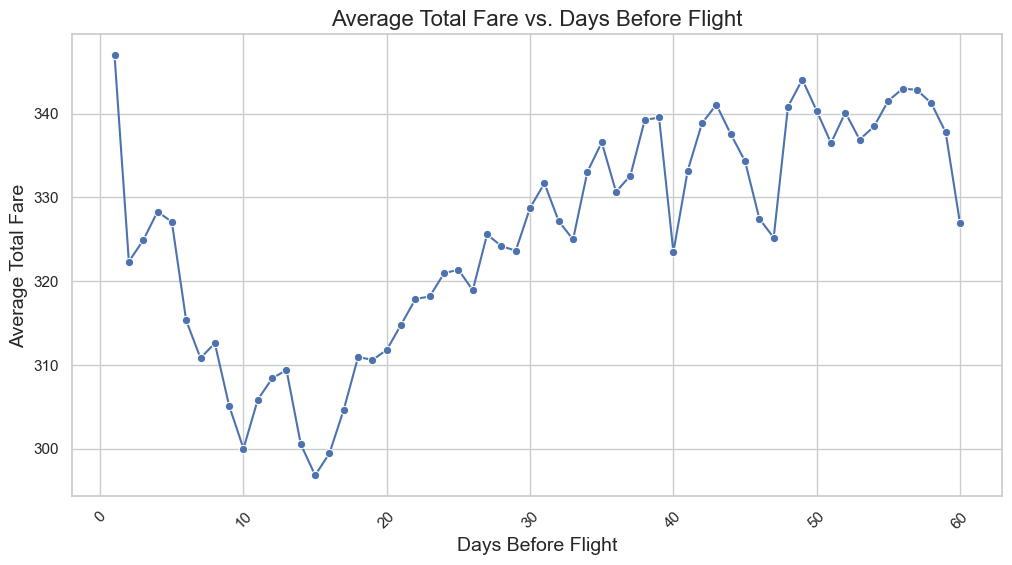

In [258]:
# Calculate average total fare by days before flight
avg_fare_by_days = data.groupby('date_diff_days')['totalFare'].mean().reset_index()

# Create a line plot
plt.figure(figsize=(12, 6))
sns.lineplot(x='date_diff_days', y='totalFare', data=avg_fare_by_days, marker='o')
plt.title('Average Total Fare vs. Days Before Flight', fontsize=16)
plt.xlabel('Days Before Flight', fontsize=14)
plt.ylabel('Average Total Fare', fontsize=14)
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


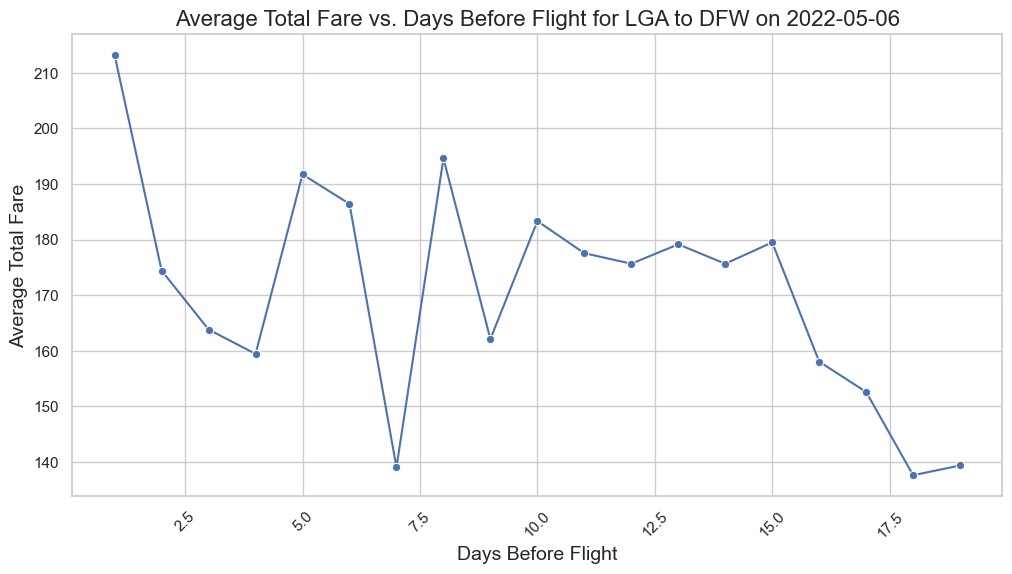

In [259]:
# Specify the criteria for a single flight
starting_airport = 'LGA'  # Change this to your desired starting airport
destination_airport = 'DFW'  # Change this to your desired destination airport
specific_flight_date = '2022-05-06'  # Change this to your desired flight date

# Filter the data for the specific flight
single_flight_data = data[(data['startingAirport'] == starting_airport) & 
                           (data['destinationAirport'] == destination_airport) & 
                           (data['flightDate'] == specific_flight_date)]

# Calculate average total fare by days before flight for this specific flight
avg_fare_by_days = single_flight_data.groupby('date_diff_days')['totalFare'].mean().reset_index()

# Create a line plot
plt.figure(figsize=(12, 6))
sns.lineplot(x='date_diff_days', y='totalFare', data=avg_fare_by_days, marker='o')
plt.title(f'Average Total Fare vs. Days Before Flight for {starting_airport} to {destination_airport} on {specific_flight_date}', fontsize=16)
plt.xlabel('Days Before Flight', fontsize=14)
plt.ylabel('Average Total Fare', fontsize=14)
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


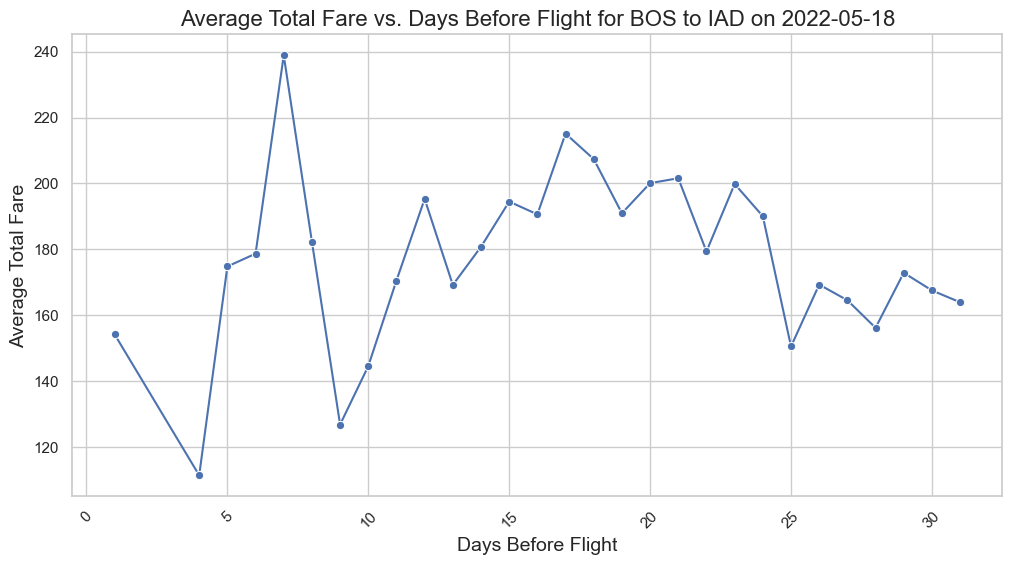

In [260]:
# Specify the criteria for another single flight
starting_airport = 'BOS'  # Change this to your desired starting airport
destination_airport = 'IAD'  # Change this to your desired destination airport
specific_flight_date = '2022-05-18'  # Change this to your desired flight date

# Filter the data for this specific flight
another_flight_data = data[(data['startingAirport'] == starting_airport) & 
                            (data['destinationAirport'] == destination_airport) & 
                            (data['flightDate'] == specific_flight_date)]

# Calculate average total fare by days before flight for this specific flight
avg_fare_by_days_another = another_flight_data.groupby('date_diff_days')['totalFare'].mean().reset_index()

# Create a line plot
plt.figure(figsize=(12, 6))
sns.lineplot(x='date_diff_days', y='totalFare', data=avg_fare_by_days_another, marker='o')
plt.title(f'Average Total Fare vs. Days Before Flight for {starting_airport} to {destination_airport} on {specific_flight_date}', fontsize=16)
plt.xlabel('Days Before Flight', fontsize=14)
plt.ylabel('Average Total Fare', fontsize=14)
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


In [261]:
data.head()

,searchDate,flightDate,startingAirport,destinationAirport,isNonStop,totalFare,totalTravelDistance,segmentsArrivalAirportCode,DepartureTimeHour,CabinCode,AirlineNameScore,date_diff_days,weekday,average_price
0,2022-04-18,2022-05-06,LGA,DFW,True,93.599998,1380.0,DFW,8,1.0,2,18,4,218.513184
1,2022-05-11,2022-05-18,BOS,IAD,False,207.600006,406.0,JFK||IAD,11,1.0,4,7,2,233.873978
2,2022-05-08,2022-06-21,ORD,EWR,False,358.600006,725.0,DTW||EWR,14,1.0,4,44,1,233.211212
3,2022-05-08,2022-05-18,OAK,BOS,False,728.599976,2688.0,SLC||BOS,17,1.0,4,10,2,597.794067
4,2022-05-12,2022-07-01,DFW,ATL,True,228.600006,725.0,ATL,19,1.0,4,50,4,260.961975


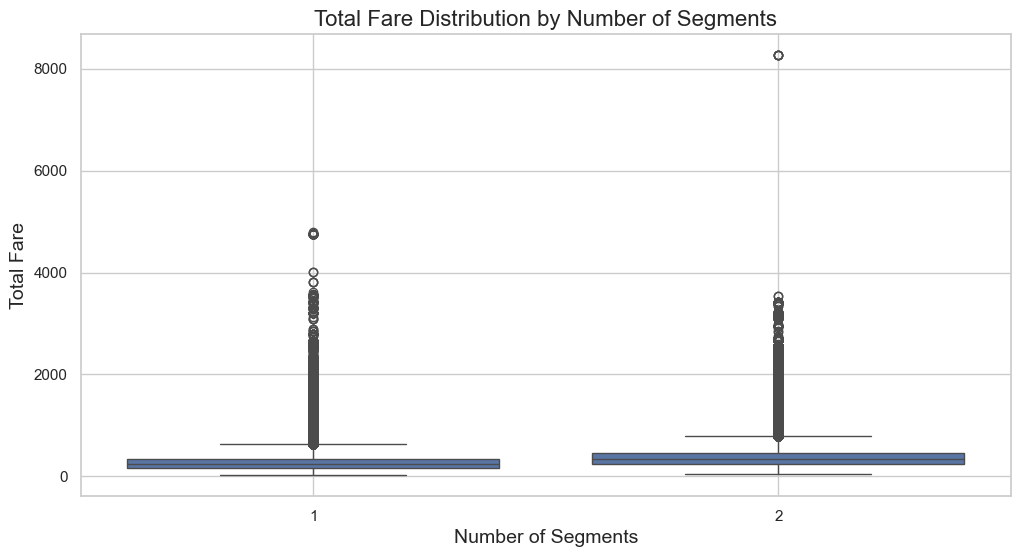

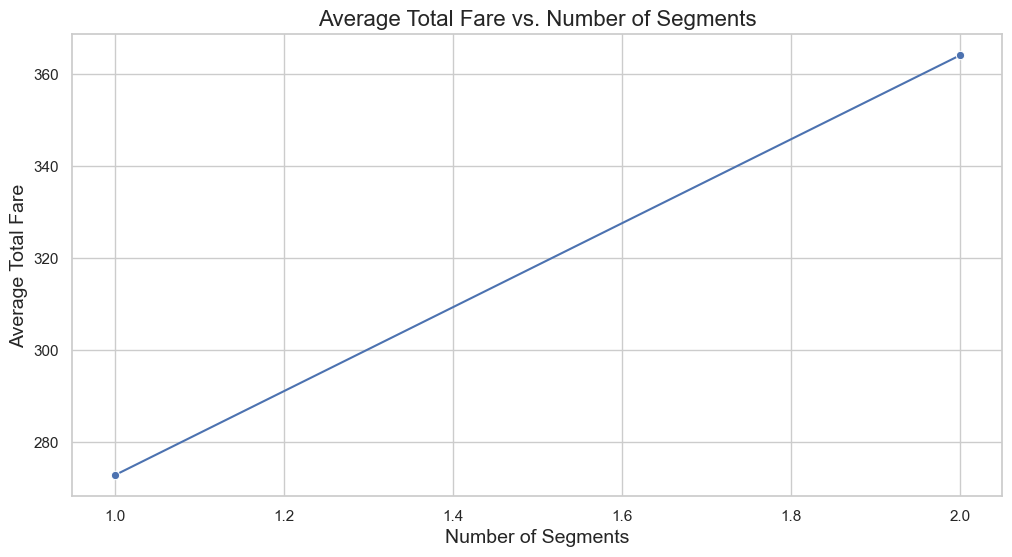

In [262]:
# Create a feature to count the number of segments
data['num_segments'] = data['segmentsArrivalAirportCode'].apply(lambda x: len(x.split('||')))

# Visualize the relationship between number of segments and total fare
plt.figure(figsize=(12, 6))
sns.boxplot(x='num_segments', y='totalFare', data=data)
plt.title('Total Fare Distribution by Number of Segments', fontsize=16)
plt.xlabel('Number of Segments', fontsize=14)
plt.ylabel('Total Fare', fontsize=14)
plt.grid(True)
plt.show()

# Optionally, calculate the average fare by number of segments
avg_fare_by_segments = data.groupby('num_segments')['totalFare'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x='num_segments', y='totalFare', data=avg_fare_by_segments, marker='o')
plt.title('Average Total Fare vs. Number of Segments', fontsize=16)
plt.xlabel('Number of Segments', fontsize=14)
plt.ylabel('Average Total Fare', fontsize=14)
plt.grid(True)
plt.show()


In [263]:
data.head()

,searchDate,flightDate,startingAirport,destinationAirport,isNonStop,totalFare,totalTravelDistance,segmentsArrivalAirportCode,DepartureTimeHour,CabinCode,AirlineNameScore,date_diff_days,weekday,average_price,num_segments
0,2022-04-18,2022-05-06,LGA,DFW,True,93.599998,1380.0,DFW,8,1.0,2,18,4,218.513184,1
1,2022-05-11,2022-05-18,BOS,IAD,False,207.600006,406.0,JFK||IAD,11,1.0,4,7,2,233.873978,2
2,2022-05-08,2022-06-21,ORD,EWR,False,358.600006,725.0,DTW||EWR,14,1.0,4,44,1,233.211212,2
3,2022-05-08,2022-05-18,OAK,BOS,False,728.599976,2688.0,SLC||BOS,17,1.0,4,10,2,597.794067,2
4,2022-05-12,2022-07-01,DFW,ATL,True,228.600006,725.0,ATL,19,1.0,4,50,4,260.961975,1


In [264]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd

# Assuming 'data' is your DataFrame with all relevant features
# Select features
features = ['totalTravelDistance', 'date_diff_days','AirlineNameScore' ,'weekday','DepartureTimeHour', 
            'startingAirport', 'destinationAirport', 'isNonStop', 'CabinCode']

X = data[features]
y = data['totalFare']

# Define categorical and numerical columns
categorical_cols = ['startingAirport', 'destinationAirport']
numerical_cols = ['CabinCode','totalTravelDistance', 'date_diff_days','AirlineNameScore' ,'DepartureTimeHour','weekday'] #, 'average_price'

# Create transformers for both types of columns
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())  # Standardize numerical features
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore'))  # One-hot encode categorical features
])

# Combine transformers into a single ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Prepare the final dataset
X_preprocessed = preprocessor.fit_transform(X)




In [265]:
# Now, prepare the test data
X_test = tdf[features]  # Use the same features as the training set
# Transform the test data using the already fitted preprocessor
X_test_preprocessed = preprocessor.transform(X_test)

In [266]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np

# Step 1: Train the XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
model.fit(X_preprocessed, y)

# Step 2: Make predictions on the test set
y_pred = model.predict(X_test_preprocessed)

# Step 3: Calculate RMSE
rmse = np.sqrt(mean_squared_error(tdf['totalFare'], y_pred))  # Assuming 'totalFare' is the true target in tdf
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')


Root Mean Squared Error (RMSE): 103.59


In [268]:
# Step 4: Print actual and predicted values
comparison_df = pd.DataFrame({
    'Actual': tdf['totalFare'].values,
    'Predicted': y_pred
})
print("\nActual vs Predicted values:")
print(comparison_df)


Actual vs Predicted values:
             Actual   Predicted
0        555.609985  403.470886
1        394.200012  353.705231
2        758.599976  479.126740
3        338.589996  276.755676
4        308.600006  427.598724
...             ...         ...
1276646  158.600006  177.536728
1276647  357.600006  520.976624
1276648  502.209991  335.533203
1276649  212.199997  176.323639
1276650  208.610001  177.204620

[1276651 rows x 2 columns]


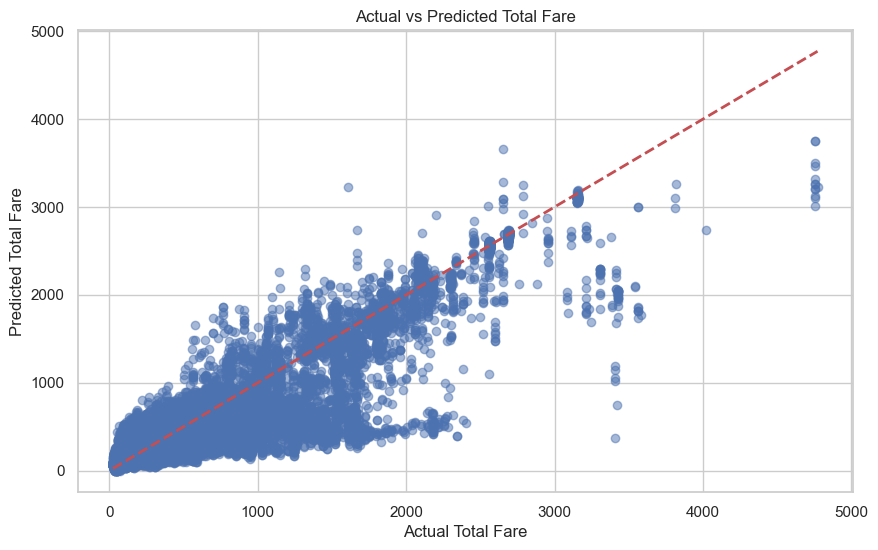

In [269]:
# Step 5: Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(comparison_df['Actual'], comparison_df['Predicted'], alpha=0.5)
plt.plot([comparison_df['Actual'].min(), comparison_df['Actual'].max()],
         [comparison_df['Actual'].min(), comparison_df['Actual'].max()],
         'r--', lw=2)
plt.xlabel('Actual Total Fare')
plt.ylabel('Predicted Total Fare')
plt.title('Actual vs Predicted Total Fare')
plt.show()

In [267]:
import joblib

# Save model to a file
joblib.dump(model, '../models/xgboost_model.joblib')

# To load the model back later
#model = joblib.load('xgboost_model.joblib')


['../models/xgboost_model.joblib']

In [275]:
# Function to evaluate model
def evaluate_model(model, X_test, y_test, feature_names):
    """
    Evaluate the regression model's performance using RMSE, MSE, and Permutation Feature Importance.

    Parameters:
    - model: Trained regression model (e.g., XGBoost)
    - X_test: Test features (scaled)
    - y_test: True target values for the test set
    - feature_names: List of original feature names for interpretability

    Returns:
    - rmse: Root Mean Squared Error
    - mse: Mean Squared Error
    - feature_importance: DataFrame containing permutation feature importance
    """
    
    # Step 1: Make predictions
    y_pred = model.predict(X_test)

    # Step 2: Calculate RMSE and MSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mse = mean_squared_error(y_test, y_pred)

    # Step 3: Calculate permutation feature importance
    perm_importance = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=42)
    
    # Step 4: Create a DataFrame for feature importance
    feature_importance = pd.DataFrame({
        'Feature': feature_names,  # Use provided feature names
        'Importance': perm_importance.importances_mean,
        'Std Dev': perm_importance.importances_std
    })
    
    return rmse, mse, feature_importance

# Evaluate the model using the evaluate_model function
original_feature_names = numerical_cols + categorical_cols  # Original feature names for interpretability
rmse, mse, feature_importance_df = evaluate_model(model, X_test_preprocessed, tdf['totalFare'], original_feature_names)

# Print the results
print(f'RMSE: {rmse:.2f}, MSE: {mse:.2f}')
print(feature_importance_df.sort_values(by='Importance', ascending=False))


ValueError: All arrays must be of the same length

In [277]:
import numpy as np
import pandas as pd
from lime.lime_tabular import LimeTabularExplainer

# Assuming 'X_preprocessed' is your scaled training data and 'model' is your trained XGBoost model

# Step 1: Create a LIME explainer
explainer = LimeTabularExplainer(
    training_data=data,
    feature_names=numerical_cols + categorical_cols,  # Original feature names (for interpretability)
    mode='regression',
    discretize_continuous=True  # Discretize continuous features for better interpretation
)

# Step 2: Choose an instance to explain (e.g., the first instance in the test set)
instance_index = 0  # Change this to the index of the instance you want to explain
instance = data[instance_index].reshape(1, -1)  # Reshape for single instance

# Step 3: Generate LIME explanation for the instance
explanation = explainer.explain_instance(
    data_row=instance[0],
    predict_fn=model.predict
)

# Step 4: Visualize the explanation
# You can visualize the explanation directly
explanation.show_in_notebook(show_table=True)


InvalidIndexError: (slice(None, None, None), 0)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
import lime
import lime.lime_tabular

# Model Evaluation Function
def evaluate_models(models, X_train, y_train, X_test, y_test, is_classification=False):
    results = []
    
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        
        # Make predictions and calculate performance metric
        if is_classification:
            predictions = model.predict(X_test)
            performance_metric = accuracy_score(y_test, predictions)
        else:
            predictions = model.predict(X_test)
            performance_metric = np.sqrt(mean_squared_error(y_test, predictions))
        
        # Calculate permutation importance
        perm_importance = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=42, n_jobs=-1)
        feature_importance = perm_importance.importances_mean
        
        # Store results
        results.append({
            'Model': model_name,
            'Performance Metric': performance_metric,
            'Feature Importance': feature_importance
        })
    
    results_df = pd.DataFrame(results)
    return results_df

# LIME Explanation Function
def explain_with_lime(model, X_train, X_test, feature_names):
    explainer = lime.lime_tabular.LimeTabularExplainer(
        training_data=X_train,
        feature_names=feature_names,
        mode='regression' if model.__class__.__name__ in ['XGBRegressor', 'MLPRegressor'] else 'classification'
    )
    
    # Explain each instance in the test set
    for i in range(len(X_test)):
        exp = explainer.explain_instance(X_test[i].flatten(), model.predict)
        exp.show_in_notebook(show_table=True)

# Updated Partial Dependence Plot Function to handle feature indices
def plot_partial_dependence_with_indices(model, X, feature_indices):
    display = PartialDependenceDisplay.from_estimator(
        model,
        X,
        features=feature_indices,
        grid_resolution=50
    )
    plt.show()

# Wrapper Function to Call All Evaluations
def model_eval(models, X_train, y_train, X_test, y_test, feature_names, is_classification=False):
    results_df = evaluate_models(models, X_train, y_train, X_test, y_test, is_classification)
    return results_df

# Individual calls for evaluation, explanation, and plotting
def run_evaluation(models, X_train, y_train, X_test, y_test, feature_names, is_classification=False):
    results_df = model_eval(models, X_train, y_train, X_test, y_test, feature_names, is_classification)
    print("Model Evaluation Results:")
    print(results_df)

def run_lime_explanation(model, X_train, X_test, feature_names):
    print("\nLIME Explanations:")
    explain_with_lime(model, X_train, X_test, feature_names)

def run_partial_dependence(model, X, feature_names):
    print("\nPartial Dependence Plots:")
    plot_partial_dependence_with_indices(model, X, feature_names)


In [242]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
import lime
import lime.lime_tabular

# Model Evaluation Function
def evaluate_models(models, X_train, y_train, X_test, y_test, is_classification=False):
    results = []
    
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        
        # Make predictions and calculate performance metric
        if is_classification:
            predictions = model.predict(X_test)
            performance_metric = accuracy_score(y_test, predictions)
        else:
            predictions = model.predict(X_test)
            performance_metric = np.sqrt(mean_squared_error(y_test, predictions))
        
        # Calculate permutation importance
        perm_importance = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=42, n_jobs=-1)
        feature_importance = perm_importance.importances_mean
        
        # Store results
        results.append({
            'Model': model_name,
            'Performance Metric': performance_metric,
            'Feature Importance': feature_importance
        })
    
    results_df = pd.DataFrame(results)
    return results_df

# LIME Explanation Function
def explain_with_lime(model, X_train, X_test, feature_names):
    explainer = lime.lime_tabular.LimeTabularExplainer(
        training_data=X_train,
        feature_names=feature_names,
        mode='regression' if model.__class__.__name__ in ['XGBRegressor', 'MLPRegressor'] else 'classification'
    )
    
    # Explain each instance in the test set
    for i in range(len(X_test)):
        exp = explainer.explain_instance(X_test[i].flatten(), model.predict)
        exp.show_in_notebook(show_table=True)

# Updated Partial Dependence Plot Function to handle feature indices
def plot_partial_dependence_with_indices(model, X, feature_indices):
    display = PartialDependenceDisplay.from_estimator(
        model,
        X,
        features=feature_indices,
        grid_resolution=50
    )
    plt.show()

# Wrapper Function to Call All Evaluations
def model_eval(models, X_train, y_train, X_test, y_test, feature_names, is_classification=False):
    results_df = evaluate_models(models, X_train, y_train, X_test, y_test, is_classification)
    return results_df

# Individual calls for evaluation, explanation, and plotting
def run_evaluation(models, X_train, y_train, X_test, y_test, feature_names, is_classification=False):
    results_df = model_eval(models, X_train, y_train, X_test, y_test, feature_names, is_classification)
    print("Model Evaluation Results:")
    print(results_df)

def run_lime_explanation(model, X_train, X_test, feature_names):
    print("\nLIME Explanations:")
    explain_with_lime(model, X_train, X_test, feature_names)

def run_partial_dependence(model, X, feature_names):
    print("\nPartial Dependence Plots:")
    plot_partial_dependence_with_indices(model, X, feature_names)


In [244]:
# Import necessary libraries and modules
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np

# Step 1: Create the dictionary of models
models = {
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42),
    # Add other models if necessary
}

# Step 2: Define feature names (must match the order used in the ColumnTransformer)
feature_names = ['totalTravelDistance', 'date_diff_days', 'AirlineNameScore', 'weekday', 
                 'startingAirport', 'destinationAirport', 'isNonStop', 'CabinCode']

# Step 3: Run model evaluation to get performance metrics and permutation importances
# print("Running model evaluation...")
# results_df = run_evaluation(models, X_preprocessed, y, X_test_preprocessed, tdf['totalFare'], feature_names, is_classification=False)

# Step 4: Get the first model in the dictionary for LIME explanations and partial dependence
first_model = list(models.values())[0]

# Step 5: Run LIME explanation on a subset of test instances
# print("\nRunning LIME explanations for the first few test instances...")
# for i in range(3):  # Choose a number of instances to explain (e.g., first 3 instances)
#     print(f"Explanation for test instance {i+1}:")
#     explain_with_lime(first_model, X_preprocessed, X_test_preprocessed[i:i+1], feature_names)

# Step 6: Run Partial Dependence Plotting for selected features
print("\nGenerating Partial Dependence Plots...")
run_partial_dependence(first_model, X_test_preprocessed, feature_names)



Generating Partial Dependence Plots...

Partial Dependence Plots:


ValueError: Feature 'totalTravelDistance' not in feature_names

In [245]:
print(X_test_preprocessed)

[[-0.06768924  0.81593233 -0.12621917 ...  0.          0.
   0.        ]
 [-0.06768924  0.41868123  1.20573616 ...  0.          0.
   0.        ]
 [-0.06768924  0.47684571 -1.45817459 ...  1.          0.
   0.        ]
 ...
 [-0.06768924 -0.24587907  0.10542525 ...  0.          0.
   0.        ]
 [-0.06768924 -1.14804757  0.10542525 ...  0.          0.
   1.        ]
 [-0.06768924 -1.07131994  1.26364732 ...  0.          0.
   0.        ]]
